In [1]:
using Pkg
Pkg.activate("../")
Pkg.status()
Pkg.instantiate()

  Activating environment at `~/WORK/HPL/Code/ina-julia/Project.toml`


      Status `~/WORK/HPL/Code/ina-julia/Project.toml`
  [6e4b80f9] BenchmarkTools v1.1.4
  [a134a8b2] BlackBoxOptim v0.6.0
  [336ed68f] CSV v0.9.0 ⚲
  [a93c6f00] DataFrames v1.2.2
  [0c46a032] DifferentialEquations v6.18.0
  [31c24e10] Distributions v0.24.18
  [a75be94c] GalacticOptim v2.0.3
  [7073ff75] IJulia v1.23.2
  [c7f686f2] MCMCChains v4.14.1
  [429524aa] Optim v1.4.1
  [91a5bcdd] Plots v1.21.3
  [c3572dad] Sundials v4.5.3
  [0c5d862f] Symbolics v3.2.3
  [bd369af6] Tables v1.5.1
  [fce5fe82] Turing v0.17.4
  [ea10d353] WeakRefStrings v1.3.0


# Load packages

In [2]:
using DifferentialEquations
using Sundials
using DataFrames: DataFrame
using CSV: File as CSVFile

using Plots
using BenchmarkTools

# Load CSV

In [3]:
read_csv(filename) = DataFrame(CSVFile(filename))

read_csv (generic function with 1 method)

In [4]:
dirname_data = "../data"
dirname_legends = joinpath(dirname_data, "legends")
dirname_protocols = joinpath(dirname_data, "protocols")

filename_legend_constants = joinpath(dirname_legends, "legend_constants_v3.csv")
filename_legend_states = joinpath(dirname_legends, "legend_states.csv")
filename_protocol = joinpath(dirname_protocols, "protocol_sparse.csv");

In [6]:
legend_states = read_csv(filename_legend_states)
legend_constants = read_csv(filename_legend_constants)
protocol = read_csv(filename_protocol);

In [7]:
find_step(t, protocol=protocol) = protocol.v[findfirst(x -> x >= t, protocol.t)]

function create_p_from_legend(legend)
    name = Symbol.(legend_constants.name)
    value = legend_constants.value
    p = (; zip(name, value)...)
end

create_p_from_legend (generic function with 1 method)

# Load equations

In [8]:
include("../src/models/ina.jl");
include("../src/models/currents.jl");
include("../src/losses.jl")

calculate_rmse (generic function with 1 method)

# Define model

In [9]:
function compute_algebraic(du, u, p, t)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
        
    tau_m  = calculate_tau_m(v_m, p)
    tau_h  = calculate_tau_h(v_m, p)
    tau_j  = calculate_tau_j(v_m, p)
    
    m_inf  = calculate_m_inf(v_m, p)
    h_inf  = calculate_h_inf(v_m, p)
    
    v_cp   = calculate_v_cp(v_comp, p)

    I_leak = 0 # calculate_I_leak(v_m, p)
    I_Na   = calculate_I_Na(v_m, m, h, j, p)
    I_c    = 0 # calculate_I_c(v_m, v_cp, I_leak, I_Na,  p)  # or calculate_I_c(v_m, v_p, I_leak, I_Na,  p)
    I_p    = 0  # or calculate_I_p(v_cp, v_p, p)
    I_comp = 0 # calculate_I_comp(v_comp, p)
    
    I_in   = I_leak + I_Na + I_c - I_comp + I_p
    
    a = (;
     tau_m, tau_h, tau_j, m_inf, h_inf,
     v_cp,
     I_leak, I_Na, I_c, I_comp, I_in
    )
    
end

compute_algebraic (generic function with 1 method)

In [10]:
function compute_rates!(du, u, p, t; safety_factor=0.)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
    
    a = compute_algebraic(du, u, p, t)
    
    du[1] = calculate_d_v_comp(v_comp, p)  # v_comp
    
    @unpack v_cp, I_leak, I_Na = a
    du[2] = 0#calculate_d_v_p(v_cp, v_p, p)  # v_p
    du[3] = calculate_d_v_m(v_m, v_cp, I_leak, I_Na, p)  # v_m
        
    @unpack m_inf, tau_m, h_inf, tau_h, tau_j = a
    du[4] = calculate_d_gate(m_inf, m, tau_m + safety_factor)  # m
    du[5] = calculate_d_gate(h_inf, h, tau_h + safety_factor)  # h
    du[6] = calculate_d_gate(h_inf, j, tau_j)  # j
        
    @unpack I_in = a
    @unpack tau_z = p
    du[7] = calculate_d_gate(I_in, I_out, tau_z)  # I_out
    
    nothing
end

compute_rates! (generic function with 1 method)

In [11]:
rhs = ODEFunction(compute_rates!, syms=[:v_comp, :v_p, :v_m, :m, :h, :j, :I_out]);

# Callbacks

In [12]:
function change_step_v1!(integrator)
    t = integrator.t
    v_c = find_step(t)
    integrator.p["v_c"] = v_c
    set_proposed_dt!(integrator, 1e-7)
    nothing
end

cb_step_v1  = PresetTimeCallback(protocol.t, change_step_v1!, save_positions=(false, false));

# Global constants

In [13]:
const u₀ = [-80., -80., -80., 0., 1., 1., 0.];
const reltol = 1e-3
const abstol = [1e-2, 1e-2, 1e-2, 1e-4, 1e-4, 1e-4, 1e-2]
const solver = CVODE_BDF();
const dt = 1e-9  # initial
const tspan_initial = (0., 10.)
const tspan = (0., 5.)
const saveat = 5e-5 # tspan[1]: 5e-5: tspan[2]

5.0e-5

# Loss

In [14]:
kwargs_loss_robust = (α=-2, c=0.1)

(α = -2, c = 0.1)

In [15]:
# p_dict = Dict{String, Real}(zip(legend_constants.name, legend_constants.value));
p_dict = Dict{String, Float64}(zip(legend_constants.name, legend_constants.value));

p_dict["α"] = kwargs_loss_robust.α

-2

In [16]:
p_keys_opt_m = ["a0_m", "s_m", "b0_m", "delta_m", "v_half_m", "k_m"]
p_keys_opt_h = ["a0_h", "s_h", "b0_h", "delta_h", "v_half_h", "k_h"]
p_keys_opt_j = ["tau_j_const", "a0_j", "s_j", "b0_j", "delta_j"]

p_keys_opt_INa = ["g_max"]

p_keys_opt_other = ["α"]  # loss_robust
p_keys_opt_patch = ["c_p","c_m","R","R_f","g_leak","tau_z","x_c_comp","x_r_comp"]
p_keys_alpha = ["alpha"]

1-element Vector{String}:
 "alpha"

In [17]:
# p_keys_opt = vcat(p_keys_opt_m, p_keys_opt_h, p_keys_opt_j)
p_keys_opt = vcat(p_keys_opt_INa, p_keys_opt_other, p_keys_opt_m, p_keys_opt_h, p_keys_opt_j)#, p_keys_opt_patch, p_keys_alpha)

19-element Vector{String}:
 "g_max"
 "α"
 "a0_m"
 "s_m"
 "b0_m"
 "delta_m"
 "v_half_m"
 "k_m"
 "a0_h"
 "s_h"
 "b0_h"
 "delta_h"
 "v_half_h"
 "k_h"
 "tau_j_const"
 "a0_j"
 "s_j"
 "b0_j"
 "delta_j"

In [18]:
legend_subset = legend_constants[in(p_keys_opt).(legend_constants.name), :]

,name,value,bound_1,bound_2,is_log
,String1…,Float64,Float64,Float64,Int64
1,a0_m,16529.1,10000.0,100000.0,1
2,b0_m,386.7,100.0,1000.0,1
3,delta_m,22.823,1.0,100.0,0
4,s_m,12.8321,1.0,100.0,0
5,a0_h,6.26,1.0,100.0,1
6,b0_h,58131.4,10000.0,100000.0,1
7,delta_h,10.2758,1.0,100.0,0
8,s_h,21.62,1.0,100.0,0
9,a0_j,0.6462,0.01,1.0,1


In [19]:
legend_subset.is_log .= true;

In [20]:
mask_log = Dict(zip(legend_subset.name,
                    Array{Bool}(legend_subset.is_log)));
mask_log["α"] = Bool(0)

false

In [21]:
function prepare_p(x, p_keys_opt, p_dict, mask_log, kwargs_loss)
    
    @assert length(x) == length(p_keys_opt)
    
    p = deepcopy(p_dict)
    for (k, v, is_log) in zip(p_keys_opt, x, mask_log)
        p[k] = mask_log[k] ? exp(v) : v
    end
    
    p["α"] = kwargs_loss.α
    
    return p
    
end

prepare_p (generic function with 1 method)

In [22]:
function sanity_checks(p)  # TODO
    v_m_range = -100:1:50
    
    τ_m, τ_h, τ_j = [map(v_m -> calculate_τ(v_m, p), v_m_range) for calculate_τ ∈ (calculate_tau_m,
                                                                                   calculate_tau_h, 
                                                                                   calculate_tau_j)]
    
    (τ_m_max, τ_m_idxmax), (τ_h_max, τ_h_idxmax), (τ_j_max, τ_j_idxmax) = map(τ -> findmax(τ), (τ_m, τ_h, τ_j))
    τ_m_min, τ_h_min, τ_j_min = map(τ -> min(τ...), (τ_m, τ_h, τ_j))

    flags = [all(1e-7 .< τ_m_min .< 1e-3),
             all(1e-8 .< τ_h_min .< 1e-2),
             all(5e-4 .< τ_j_min .< 2.),
             τ_m_max > 4e-5,
             τ_h_max > 1e-3,
             τ_j_max > 8e-2,
             (-90. < v_m_range[τ_m_idxmax] < 0.),
             (-90. < v_m_range[τ_h_idxmax] < 0.),
             (-90. < v_m_range[τ_j_idxmax] < 0.)]
end

sanity_checks (generic function with 1 method)

In [23]:
function solve_model(prob, remake_kwargs, solve_kwargs)
    prob_remade = remake(prob; remake_kwargs...)
    sol = solve(prob_remade; solve_kwargs...)
end

solve_model (generic function with 1 method)

In [45]:
function calculate_data_segmented(x, p_kwargs, prob, solve_kwargs_default, n_steps=20)::Vector{Float64}
    
    tspan_end = 5.
    step_size = 5e-5
    segment_size_sec = tspan_end / n_steps
    segment_size_timestamps = Int(tspan_end / n_steps / step_size)
    
    data_segmented = fill(Inf, Int(round(tspan_end / step_size) + 1))
            
    p = prepare_p(x, p_kwargs...)
    is_ok = all(sanity_checks(p))
    if !is_ok
        return data_segmented
    end
    
    @unpack reltol, abstol, solver, saveat, dt = solve_kwargs_default
    
    # equilibrium
    t_eq_end = 10.
    remake_kwargs = (p=p, tspan=(0., t_eq_end), callback=nothing)
    solve_kwargs = (saveat=[t_eq_end], reltol, abstol, solver, dt)

    sol_eq = solve_model(prob, remake_kwargs, solve_kwargs)
    if sol_eq.retcode ≠ :Success
        return data_segmented
    end
    u∞ = sol_eq.u[end]
        
    Threads.@threads for i in 1: n_steps
        
        tspan_segment = (segment_size_sec * (i - 1),
                         segment_size_sec * i)
        remake_kwargs = (u0=u∞, p=deepcopy(p), tspan=tspan_segment)
        sol_segment = solve_model(prob, remake_kwargs, solve_kwargs_default)
                
        if sol_segment.retcode == :Success
            data_segmented[(i - 1) * segment_size_timestamps + 1 : i * segment_size_timestamps + 1] = sol_segment[:I_out]
        else
            break
        end
        
    end
    
    return data_segmented

end

calculate_data_segmented (generic function with 2 methods)

In [46]:
function calculate_loss_segments(data, x, p_kwargs, prob, solve_kwargs_default, n_steps=20)::Float64
    
    data_segmented = calculate_data_segmented(x, p_kwargs, prob, solve_kwargs_default, n_steps)
    
    if all(isfinite.(data_segmented))
        residuals = data_segmented - data
        loss = calculate_loss_robust.(residuals, α=p["α"], c=0.1)
        loss = mean(loss)
    else
        loss = Inf
    end
    
    return loss
        
end

calculate_loss_segments (generic function with 2 methods)

In [26]:
# function calculate_loss_segments(x, p_kwargs, prob, solve_kwargs_default, return_data=false, n_steps=20)
            
#     p = prepare_p(x, p_kwargs...)
    
#     @unpack reltol, abstol, solver, saveat, dt = solve_kwargs_default
    
#     # equilibrium
#     t_eq_end = 10.
#     remake_kwargs = (p=p, tspan=(0., t_eq_end), callback=nothing)
#     solve_kwargs = (saveat=[t_eq_end], reltol, abstol, solver, dt)

#     sol_eq = solve_model(prob, remake_kwargs, solve_kwargs)
#     if sol_eq.retcode ≠ :Success
#         loss = Inf
#         return loss, nothing
#     end
#     u∞ = sol_eq.u[end]

#     Threads.@threads for i in 1: n_steps
#         sol_segment = solve_model(prob, (u0=u∞, p=deepcopy(p), tspan=(2.25, 2.5)), solve_kwargs_default)
#     end
    
# end





# Generate data

In [47]:
x₀ = [mask_log[k] ? log.(p_dict[k]) : p_dict[k] for k in p_keys_opt];

In [48]:
p_kwargs = (; p_keys_opt, p_dict, mask_log, kwargs_loss_robust);

In [49]:
p = prepare_p(x₀, p_kwargs...)

Dict{String, Float64} with 31 entries:
  "g_max"       => 3392.4
  "s_m"         => 12.8321
  "b0_j"        => 11358.3
  "tau_z"       => 0.000100034
  "b0_m"        => 386.7
  "b0_h"        => 58131.4
  "v_half_h"    => 59.6912
  "tau_j_const" => 0.00132
  "c_m"         => 2.47302e-11
  "s_j"         => 69.417
  "v_off"       => -2.0
  "R_f"         => 3.26421e5
  "c_p"         => 4.50296e-13
  "s_h"         => 21.62
  "k_h"         => 5.50777
  "x_c_comp"    => 0.01
  "alpha"       => 0.75
  "v_rev"       => 18.0
  "α"           => -2.0
  "v_half_m"    => 28.358
  "delta_h"     => 10.2758
  "x_r_comp"    => 0.2
  "v_c"         => -80.0
  "g_leak"      => 0.481244
  "delta_m"     => 22.823
  ⋮             => ⋮

In [29]:
prob = ODEProblem(rhs, u₀, tspan, p, callback=cb_step_v1)
solve_kwargs_default = (; reltol, abstol, solver, saveat, dt)

(reltol = 0.001, abstol = [0.01, 0.01, 0.01, 0.0001, 0.0001, 0.0001, 0.01], solver = CVODE_BDF{:Newton, :Dense, Nothing, Nothing}(0, 0, 0, false, 10, 5, 7, 3, 10, nothing, nothing, 0), saveat = 5.0e-5, dt = 1.0e-9)

In [30]:
sol = solve_model(prob, (;), solve_kwargs_default);

In [31]:
@benchmark solve_model(prob, (;), solve_kwargs_default)

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  225.590 ms … 275.527 ms  ┊ GC (min … max):  8.27% … 15.09%
 Time  (median):     252.253 ms               ┊ GC (median):    14.28%
 Time  (mean ± σ):   250.040 ms ±  15.881 ms  ┊ GC (mean ± σ):  11.90% ±  3.43%

  ▁  ▁█       ▁ █    ▁         ▁ ▁ ▁ ▁    ▁  █    ▁ ▁ ▁▁      ▁  
  █▁▁██▁▁▁▁▁▁▁█▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁█▁█▁█▁▁▁▁█▁▁█▁▁▁▁█▁█▁██▁▁▁▁▁▁█ ▁
  226 ms           Histogram: frequency by time          276 ms <

 Memory estimate: 200.70 MiB, allocs estimate: 2543355.

In [54]:
data = calculate_data_segmented(x₀, p_kwargs, prob, solve_kwargs_default);

In [53]:
@benchmark calculate_data_segmented(x₀, p_kwargs, prob, solve_kwargs_default)

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  223.735 ms … 283.407 ms  ┊ GC (min … max):  7.71% … 11.63%
 Time  (median):     254.037 ms               ┊ GC (median):    13.12%
 Time  (mean ± σ):   250.413 ms ±  13.971 ms  ┊ GC (mean ± σ):  11.15% ±  3.11%

  ▁    ▁   ▁    ▁▁  █ ▁        ▁▁▁ █▁▁▁▁▁ ▁                   ▁  
  █▁▁▁▁█▁▁▁█▁▁▁▁██▁▁█▁█▁▁▁▁▁▁▁▁███▁██████▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  224 ms           Histogram: frequency by time          283 ms <

 Memory estimate: 208.34 MiB, allocs estimate: 2648118.

In [51]:
loss = calculate_loss_segments(data, x₀, p_kwargs, prob, solve_kwargs_default)

0.0

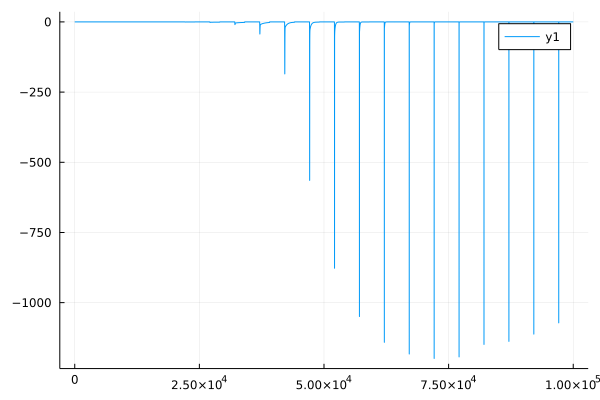

In [52]:
plot(data)